# Step 1: Set correct nnU-Net paths

In [1]:
import os

BASE = r"D:/Capstone/Experiment 3/nnUNet_2_channel"

os.environ["nnUNet_raw"] = BASE + r"/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = BASE + r"/nnUNet_preprocessed"
os.environ["nnUNet_results"] = BASE + r"/nnUNet_results"

print("nnUNet paths set:")
print("RAW:", os.environ["nnUNet_raw"])
print("PREPROCESSED:", os.environ["nnUNet_preprocessed"])
print("RESULTS:", os.environ["nnUNet_results"])


nnUNet paths set:
RAW: D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_raw
PREPROCESSED: D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_preprocessed
RESULTS: D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_results


# Step 2: Create base folders

In [2]:
os.makedirs(os.environ["nnUNet_raw"], exist_ok=True)
os.makedirs(os.environ["nnUNet_preprocessed"], exist_ok=True)
os.makedirs(os.environ["nnUNet_results"], exist_ok=True)

print("✅ Base folders ensured")


✅ Base folders ensured


# Step 3: Verify dataset folder exists

In [3]:
dataset_path = os.path.join(os.environ["nnUNet_raw"], "Dataset124_ISLES22_2CH")

if not os.path.exists(dataset_path):
    print("❌ Dataset124_ISLES22_2CH NOT FOUND in nnUNet_raw")
else:
    print("✅ Dataset found:", dataset_path)
    print("Contents:", os.listdir(dataset_path))


❌ Dataset124_ISLES22_2CH NOT FOUND in nnUNet_raw


# STEP 3: DATASET Conversion


In [4]:
import os, re, json, glob
import SimpleITK as sitk
from pathlib import Path

BIDS_ROOT = r"D:\Capstone\Experiment 3\Datasets\ISLES-2022"
OUT_ROOT  = r"D:\Capstone\Experiment 3\nnUNet_2_channel\nnUNet_raw\Dataset124_ISLES22_2CH"

IMAGES_TR = Path(OUT_ROOT, "imagesTr")
LABELS_TR = Path(OUT_ROOT, "labelsTr")
for p in (IMAGES_TR, LABELS_TR): 
    p.mkdir(parents=True, exist_ok=True)


def resample_to_ref(img, ref, is_label=False):
    """Resample img to reference image space/shape using SITK."""
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor if is_label else sitk.sitkBSpline)
    resampler.SetTransform(sitk.Transform())  # identity
    resampler.SetDefaultPixelValue(0)
    return resampler.Execute(img)


# Find all subjects
subs = sorted(glob.glob(str(Path(BIDS_ROOT, "sub-strokecase*"))))
print("Subjects found:", len(subs))

ok, failed = 0, []

for sub_path in subs:
    sub = Path(sub_path).name
    case_id = re.findall(r"\d+", sub)
    if not case_id:
        failed.append((sub, "could_not_parse_id"))
        continue

    case_num = case_id[0]

    ses = Path(sub_path, "ses-0001")
    dwi  = Path(ses, "dwi",  f"{sub}_ses-0001_dwi.nii.gz")
    adc  = Path(ses, "dwi",  f"{sub}_ses-0001_adc.nii.gz")
    label = Path(BIDS_ROOT, "derivatives", sub, "ses-0001", f"{sub}_ses-0001_msk.nii.gz")

    for needed in [dwi, adc, label]:
        if not needed.exists():
            failed.append((sub, f"missing: {needed.name}"))
            break
    else:
        try:
            dwi_img = sitk.ReadImage(str(dwi))
            adc_img = sitk.ReadImage(str(adc))
            lab_img = sitk.ReadImage(str(label))

            adc_r = resample_to_ref(adc_img, dwi_img, is_label=False)
            lab_r = resample_to_ref(lab_img, dwi_img, is_label=True)

            sz = dwi_img.GetSize()
            if adc_r.GetSize()!=sz or lab_r.GetSize()!=sz:
                failed.append((sub, f"resample_size_mismatch {sz} vs {adc_r.GetSize()}/{lab_r.GetSize()}"))
                continue

            base = f"ISLES22_{case_num}"

            sitk.WriteImage(dwi_img, str(IMAGES_TR / f"{base}_0000.nii.gz"), True)  # 0000 = DWI
            sitk.WriteImage(adc_r,   str(IMAGES_TR / f"{base}_0001.nii.gz"), True)  # 0001 = ADC
            sitk.WriteImage(lab_r,   str(LABELS_TR / f"{base}.nii.gz"), True)

            ok += 1

        except Exception as e:
            failed.append((sub, f"error: {e!s}"))


print(f"\n✅ Converted cases: {ok}")
print(f"❌ Failed cases:    {len(failed)}")
for item in failed[:10]:
    print("   ", item)


# dataset.json for 2-channel adc + dwi
ds_json = {
    "channel_names": {
        "0": "DWI",
        "1": "ADC"
    },
    "labels": {
        "background": 0,
        "stroke": 1
    },
    "numTraining": ok,
    "file_ending": ".nii.gz"
}

with open(Path(OUT_ROOT, "dataset.json"), "w", encoding="utf-8") as f:
    json.dump(ds_json, f, indent=2)

print("\n✅ dataset.json written for 2-channel (DWI + ADC)")


Subjects found: 250

✅ Converted cases: 250
❌ Failed cases:    0

✅ dataset.json written for 2-channel (DWI + ADC)


In [14]:
import os
import nibabel as nib

dataset_path = r"D:\Capstone\Experiment 3\nnUNet_raw\Dataset123_ISLES22\imagesTr"

bad_files = []
bad_shapes = []
missing_modalities = []
all_good = []

cases = {}

# Group modalities for each case ID
for f in os.listdir(dataset_path):
    if not f.endswith(".nii.gz"): 
        continue
    case_id = f.split("_")[1]
    modality_id = f.split("_")[2].split(".")[0]
    cases.setdefault(case_id, {})[modality_id] = os.path.join(dataset_path, f)

print("Total cases detected:", len(cases))


for cid, mods in cases.items():

    # Check if all 3 modalities exist
    if len(mods) != 3:
        missing_modalities.append((cid, list(mods.keys())))
        continue
    
    shapes = []
    corrupted = False

    for mid, path in mods.items():
        try:
            img = nib.load(path)
            shapes.append(img.shape)
        except Exception as e:
            bad_files.append((cid, mid, path, str(e)))
            corrupted = True

    if corrupted:
        continue

    # Check if all three shapes match
    if not (shapes[0] == shapes[1] == shapes[2]):
        bad_shapes.append((cid, shapes))
    else:
        all_good.append(cid)

print("\n✅ GOOD cases:", len(all_good))
print("❌ Corrupted files:", len(bad_files))
print("❌ Shape mismatches:", len(bad_shapes))
print("❌ Missing modality cases:", len(missing_modalities))

print("\nCorrupted file list:")
for b in bad_files:
    print(b)

print("\nShape mismatch cases:")
for b in bad_shapes:
    print(b)

print("\nMissing modality cases:")
for b in missing_modalities:
    print(b)


Total cases detected: 250

✅ GOOD cases: 250
❌ Corrupted files: 0
❌ Shape mismatches: 0
❌ Missing modality cases: 0

Corrupted file list:

Shape mismatch cases:

Missing modality cases:


In [5]:
import os
print("RAW =", os.environ.get("nnUNet_raw"))
print("PRE =", os.environ.get("nnUNet_preprocessed"))
print("RES =", os.environ.get("nnUNet_results"))


RAW = D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_raw
PRE = D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_preprocessed
RES = D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_results


In [8]:
!python -c "import nnunetv2; print('✅ nnU-Net v2 loaded successfully')"


✅ nnU-Net v2 loaded successfully


In [13]:
!nnUNetv2_plan_and_preprocess -d 124 --verify_dataset_integrity


Fingerprint extraction...
Dataset124_ISLES22_2CH
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [ 72. 112. 112.], 3d_lowres: [72, 112, 112]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 266, 'patch_size': (112, 112), 'median_image_size_in_voxels'


100%|██████████| 250/250 [00:17<00:00, 14.55it/s]

100%|██████████| 250/250 [00:25<00:00,  9.74it/s]

100%|██████████| 250/250 [00:41<00:00,  5.97it/s]


# Step 4: Preprocessed Data verification

In [14]:
import numpy as np
import nibabel as nib
import os

folder = r"D:\Capstone\Experiment 3\nnUNet_preprocessed\Dataset123_ISLES22\nnUNetPlans_3d_fullres"

bad = []

for file in os.listdir(folder):
    if file.endswith(".npz"):
        path = os.path.join(folder, file)
        try:
            _ = np.load(path)
        except Exception as e:
            bad.append((file, str(e)))

print("Bad files:", bad)
print("Count:", len(bad))


Bad files: []
Count: 0


# Step 5: 3D Model training

In [1]:
import os

# Restrict number of CPU workers to avoid crashes
os.environ["nnUNet_n_proc_lowres"] = "1"
os.environ["nnUNet_n_proc_fullres"] = "1"
os.environ["nnUNet_num_threads"] = "1"
os.environ["nnUNet_num_gpus"] = "1"

# reduce dataloader workers
os.environ["nnUNet_dataloader_num_workers"] = "0"


In [15]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
import subprocess

cmd = ["nnUNetv2_train", "123", "3d_fullres", "0"]

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

for line in process.stdout:
    print(line, end="")

process.wait()
print("\nExit code:", process.returncode)



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0
C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\nnunetv2\training\nnUNetTrainer\nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################

# Step 7: Training 2D Model

In [16]:
import nnunetv2.training.nnUNetTrainer as T
print(T.__file__)


c:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\nnunetv2\training\nnUNetTrainer\__init__.py


In [1]:
import nnunetv2.training.nnUNetTrainer as T
print([c for c in dir(T) if "200" in c.lower()])


['nnUNetTrainer_2d_200epochs']


In [ ]:
import subprocess

cmd = ["nnUNetv2_train", "123", "2d", "0"]  # dataset 123, 2D model, GPU 0

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

for line in process.stdout:
    print(line, end="")

process.wait()
print("\nTraining finished with exit code:", process.returncode)



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0
C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\nnunetv2\training\nnUNetTrainer\nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################

# Initialize

In [18]:
!nnUNetv2_train 124 2d 0 -device cuda


C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\nnunetv2\training\nnUNetTrainer\nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None
C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-11-26 23:52:53.475369: do_dummy_2d_data_aug: False
2025-11-26 23:52:53.478899: Creating new 5-fold cross-validation split...
2025-11-26 23:52:53.481902: Desired fold for training: 0
2025-11-26 23:52:53.481902: This split has 200 training and 50 validation cases.
using pin_memory on device 0

# Continue

In [1]:
!nnUNetv2_train 124 2d 0 --c



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-11-16 17:01:20.501065: do_dummy_2d_data_aug: False
2025-11-16 17:01:20.505572: Using splits from existing split file: D:\Capstone\Experiment 3\nnUNet_preprocessed\Dataset123_ISLES22\splits_final.json
2025-11-16 17:01:20.507583: The split file contains 5 splits.
2025-11-16 17:01:20.507583: D

C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\nnunetv2\training\nnUNetTrainer\nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None
C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\ankit\anaconda3\envs\nnunet-gpu\lib\site-packages\nnunetv2\training\nnUNetTrainer\nnUNetTrainer.py:1184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future re

# Step 8: 

,case,dice,iou,accuracy,precision,recall,f1_score,TP,FP,FN,TN
0,ISLES22_0010,0.691047,0.527938,0.999729,0.736559,0.650831,0.691047,274,98,147,902649
1,ISLES22_0011,0.786667,0.648352,0.999371,0.816295,0.759114,0.786667,1062,239,337,914074
2,ISLES22_0017,0.812573,0.684315,0.999303,0.937627,0.716952,0.812573,1383,92,546,913691
3,ISLES22_0019,0.875266,0.778198,0.997596,0.862334,0.888591,0.875266,7617,1216,955,893380
4,ISLES22_0021,0.810865,0.681895,0.999167,0.915389,0.727765,0.810865,1612,149,603,900804
5,ISLES22_0028,0.888124,0.798762,0.999784,0.928058,0.851485,0.888124,774,60,135,902199
6,ISLES22_0031,0.894465,0.809079,0.997364,0.910142,0.879319,0.894465,10230,1010,1404,903068
7,ISLES22_0034,0.746082,0.595000,0.999912,0.725610,0.767742,0.746082,119,45,36,915512
8,ISLES22_0041,0.845217,0.731928,0.999806,0.977867,0.744257,0.845217,486,11,167,915048
9,ISLES22_0048,0.846897,0.734450,0.997807,0.903529,0.796945,0.846897,5479,585,1396,895708



Saved: nnunet_validation_metrics.csv


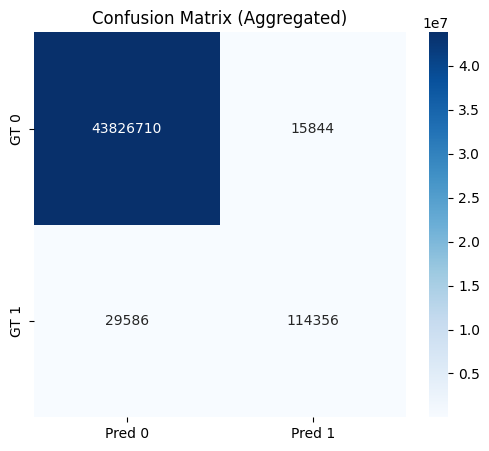

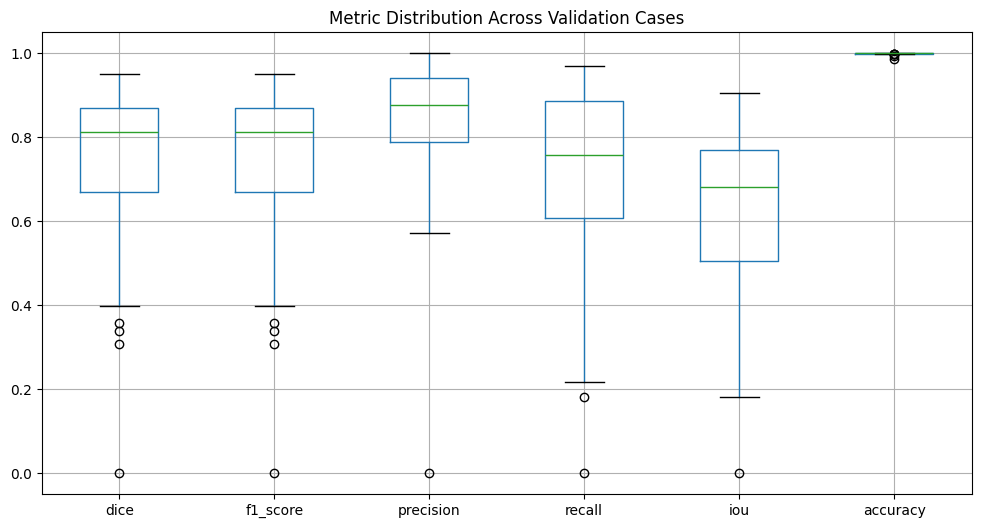

In [1]:
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

pred_dir = r"D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_results/Dataset124_ISLES22_2CH/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation"
gt_dir   = r"D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_raw/Dataset124_ISLES22_2CH/labelsTr"

metrics_list = []

def dice_coef(gt, pred):
    intersection = np.sum((gt == 1) & (pred == 1))
    return (2.0 * intersection) / (np.sum(gt == 1) + np.sum(pred == 1) + 1e-8)


for file in os.listdir(pred_dir):
    if not file.endswith(".nii.gz"):
        continue

    case_id = file.replace(".nii.gz", "")

    pred_path = os.path.join(pred_dir, file)
    gt_path   = os.path.join(gt_dir, case_id + ".nii.gz")

    if not os.path.exists(gt_path):
        print("Missing GT for:", case_id)
        continue

    pred_img = sitk.ReadImage(pred_path)
    gt_img   = sitk.ReadImage(gt_path)

    pred = sitk.GetArrayFromImage(pred_img)
    gt   = sitk.GetArrayFromImage(gt_img)

    pred_bin = (pred > 0.5).astype(np.uint8)
    gt_bin   = (gt > 0).astype(np.uint8)

    # Flatten for sklearn
    p = pred_bin.flatten()
    g = gt_bin.flatten()

    dice = dice_coef(g, p)
    acc = accuracy_score(g, p)
    prec = precision_score(g, p, zero_division=0)
    rec = recall_score(g, p, zero_division=0)
    f1 = f1_score(g, p, zero_division=0)
    iou = jaccard_score(g, p, zero_division=0)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(g, p, labels=[0,1]).ravel()

    metrics_list.append({
        "case": case_id,
        "dice": dice,
        "iou": iou,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

df = pd.DataFrame(metrics_list)

display(df)

# Save metrics to CSV
df.to_csv("nnunet_validation_metrics.csv", index=False)
print("\nSaved: nnunet_validation_metrics.csv")

# --------- Plot mean confusion matrix ----------
mean_TP = df["TP"].sum()
mean_FP = df["FP"].sum()
mean_FN = df["FN"].sum()
mean_TN = df["TN"].sum()

cm = np.array([[mean_TN, mean_FP],
               [mean_FN, mean_TP]])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["GT 0","GT 1"])
plt.title("Confusion Matrix (Aggregated)")
plt.show()

# --------- Boxplots for metrics ---------
plt.figure(figsize=(12,6))
df[["dice","f1_score","precision","recall","iou","accuracy"]].boxplot()
plt.title("Metric Distribution Across Validation Cases")
plt.show()


In [2]:
import os
import nibabel as nib
import numpy as np

# === CONFIGURATION ===

pred_folder = r"D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_results\Dataset124_ISLES22_2CH/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation"
gt_folder   = r"D:/Capstone/Experiment 3/nnUNet_2_channel/nnUNet_raw\Dataset124_ISLES22_2CH/labelsTr"

avd_list = []   # ← FIXED (line 11)

print(f"{'Case ID':<20} | {'Spacing (mm)':<20} | {'Pred Vol (ml)':<15} | {'AVD (ml)':<10}")
print("-" * 80)

# Iterate through predictions
for filename in sorted(os.listdir(pred_folder)):

    if filename.endswith(".nii.gz"):
        pred_path = os.path.join(pred_folder, filename)
        gt_path   = os.path.join(gt_folder, filename)

        # Sanity check: GT exists?
        if not os.path.exists(gt_path):
            print(f"⚠ GT not found for {filename}, skipping")
            continue

        # Load files
        pred_img = nib.load(pred_path)
        gt_img   = nib.load(gt_path)

        # Extract patient-specific spacing (CRITICAL)
        spacing = pred_img.header.get_zooms()   # (x, y, z)
        voxel_vol_mm3 = np.prod(spacing)

        # Compute volumes
        vol_pred_mm3 = np.sum(pred_img.get_fdata() > 0) * voxel_vol_mm3
        vol_gt_mm3   = np.sum(gt_img.get_fdata() > 0) * voxel_vol_mm3

        # Convert → ml
        vol_pred_ml = vol_pred_mm3 / 1000
        vol_gt_ml   = vol_gt_mm3 / 1000

        # Absolute Volume Difference
        avd = abs(vol_pred_ml - vol_gt_ml)
        avd_list.append(avd)

        spacing_str = f"[{spacing[0]:.2f}, {spacing[1]:.2f}, {spacing[2]:.2f}]"

        print(f"{filename:<20} | {spacing_str:<20} | {vol_pred_ml:<15.3f} | {avd:.3f}")

# === FINAL REPORT ===
print("-" * 80)
print("FINAL ISLES METRIC:")
print(f"Mean AVD:   {np.mean(avd_list):.3f} ml")
print(f"Median AVD: {np.median(avd_list):.3f} ml   (recommended for ISLES)")


Case ID              | Spacing (mm)         | Pred Vol (ml)   | AVD (ml)  
--------------------------------------------------------------------------------
ISLES22_0010.nii.gz  | [2.00, 2.00, 2.00]   | 2.976           | 0.392
ISLES22_0011.nii.gz  | [2.00, 2.00, 2.00]   | 10.408          | 0.784
ISLES22_0017.nii.gz  | [2.00, 2.00, 2.00]   | 11.800          | 3.632
ISLES22_0019.nii.gz  | [2.00, 2.00, 2.00]   | 70.664          | 2.088
ISLES22_0021.nii.gz  | [2.00, 2.00, 2.00]   | 14.088          | 3.632
ISLES22_0028.nii.gz  | [2.00, 2.00, 2.00]   | 6.672           | 0.600
ISLES22_0031.nii.gz  | [2.00, 2.00, 2.00]   | 89.920          | 3.152
ISLES22_0034.nii.gz  | [2.00, 2.00, 2.00]   | 1.312           | 0.072
ISLES22_0041.nii.gz  | [2.00, 2.00, 2.00]   | 3.976           | 1.248
ISLES22_0048.nii.gz  | [2.00, 2.00, 2.00]   | 48.512          | 6.488
ISLES22_0051.nii.gz  | [2.00, 2.00, 2.00]   | 2.696           | 0.424
ISLES22_0053.nii.gz  | [2.00, 2.00, 2.00]   | 0.832           | 0.112
ISLE

# Testing Area

In [3]:
import os
import shutil
import re

# ---------------------------
# CONFIGURATION
# ---------------------------
INPUT = r"D:/Capstone/Experiment 3/TEST_INPUT"
OUTPUT = r"D:/Capstone/Experiment 3/TEST_READY"  # Folder nnUNet will read from

os.makedirs(OUTPUT, exist_ok=True)

# ---------------------------
# MODALITY KEYWORD RULES
# ---------------------------
modality_map = {
    "dwi": 0,
    "diff": 0,
    "adc": 1,
    "apparent": 1,
    "flair": 2,
    "t2": 2
}

print("📌 Detected input folder:", INPUT)
files = [f for f in os.listdir(INPUT) if f.endswith(".nii.gz")]

if len(files) == 0:
    raise ValueError("❌ No .nii.gz files found in TEST_INPUT!")

print(f"🔍 Found {len(files)} NIfTI files. Checking modalities...\n")

# ---------------------------
# AUTO-DETECT CASE ID
# ---------------------------
# Remove known modality keywords & session info to isolate patient ID
def extract_case_id(filename):
    base = filename.replace(".nii.gz", "")

    # remove typical modality suffixes
    cleaned = re.sub(r"(dwi|adc|flair|t2|diff|apparent|ses-\d+|run-\d+)", "", base, flags=re.IGNORECASE)
    cleaned = cleaned.replace("__", "_").replace("-", "_")
    return cleaned.strip("_")

case_id = extract_case_id(files[0])
print("🆔 Auto-detected Case ID:", case_id, "\n")

# ---------------------------
# PROCESS FILES
# ---------------------------

assigned = {0: None, 1: None, 2: None}

for f in files:
    fname = f.lower()

    detected = None
    for key, mid in modality_map.items():
        if key in fname:
            detected = mid
            break

    if detected is None:
        print(f"⚠️ WARNING: Could NOT detect modality for {f}. Skipping.")
        continue

    new_name = f"{case_id}_{detected:04d}.nii.gz"
    src = os.path.join(INPUT, f)
    dst = os.path.join(OUTPUT, new_name)

    shutil.copy(src, dst)
    assigned[detected] = new_name

    print(f"✔ Detected {f} → modality {detected} → renamed to {new_name}")

print("\n---------------------------")
print("📦 SUMMARY")
print("---------------------------")

if assigned[0]:
    print(f"DWI   (0000): {assigned[0]}")
else:
    print("❌ DWI missing (modality 0)")

if assigned[1]:
    print(f"ADC   (0001): {assigned[1]}")
else:
    print("⚠️ ADC missing (modality 1)")

if assigned[2]:
    print(f"FLAIR (0002): {assigned[2]}")
else:
    print("⚠️ FLAIR missing (modality 2)")

print("\n📁 Ready for nnU-Net input:", OUTPUT)
print("🎉 Auto-preparation complete!")


📌 Detected input folder: D:/Capstone/Experiment 3/TEST_INPUT
🔍 Found 1 NIfTI files. Checking modalities...

🆔 Auto-detected Case ID: sub_strokecase0002 

✔ Detected sub-strokecase0002_ses-0001_dwi.nii.gz → modality 0 → renamed to sub_strokecase0002_0000.nii.gz

---------------------------
📦 SUMMARY
---------------------------
DWI   (0000): sub_strokecase0002_0000.nii.gz
⚠️ ADC missing (modality 1)
⚠️ FLAIR missing (modality 2)

📁 Ready for nnU-Net input: D:/Capstone/Experiment 3/TEST_READY
🎉 Auto-preparation complete!


In [17]:
import subprocess

command = [
    "nnUNetv2_predict",
    "-i", "D:/Capstone/Experiment 3/TEST_READY",
    "-o", "D:/Capstone/Experiment 3/TEST_OUTPUT",
    "-d", "123",
    "-c", "2d",
    "-tr", "nnUNetTrainer",
    "-f", "0"
]

result = subprocess.run(command, capture_output=True, text=True)
print("STDOUT:\n", result.stdout)
print("\nSTDERR:\n", result.stderr)
print("\nReturn code:", result.returncode)


STDOUT:
 
#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 1 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting ISLES22_0121:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with ISLES22_0121


STDERR:
 
100%|██████████| 73/73 [00:02<00:00, 26.35it/s]


Return code: 0


In [19]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

PREPROC_FOLDER = r"D:/Capstone/Experiment 3/nnUNet_preprocessed/Dataset123_ISLES22/nnUNetPlans_2d"
MASK_FOLDER = r"D:/Capstone/Experiment 3/TEST_OUTPUT"
SAVE_FOLDER  = r"D:/Capstone/Experiment 3/PNG_RESULTS"
case = "ISLES22_0121"

os.makedirs(SAVE_FOLDER, exist_ok=True)

# Load (C, S, H, W)
img = np.load(os.path.join(PREPROC_FOLDER, case + ".npy"))

# Choose ADC modality
img_vis = img[1]

# Load mask, convert to (S,H,W)
mask = nib.load(os.path.join(MASK_FOLDER, case + ".nii.gz")).get_fdata()
mask_ax = np.transpose(mask, (2,0,1))

# Custom pure red colormap
red_cmap = ListedColormap([[0,0,0,0], [1,0,0,0.7]])  
# index 0 = transparent, index 1 = red with alpha 0.7

for i in range(img_vis.shape[0]):
    if np.sum(mask_ax[i]) == 0:
        continue

    plt.figure(figsize=(6,6))
    plt.imshow(img_vis[i], cmap='gray')
    plt.imshow(mask_ax[i], cmap=red_cmap, alpha=0.7)
    plt.title(f"{case} — Slice {i} (ADC)")
    plt.axis('off')

    out_path = os.path.join(SAVE_FOLDER, f"{case}_overlay_slice_{i}.png")
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

print("DONE — Overlays saved.")


DONE — Overlays saved.


In [20]:
import numpy as np

mask = np.transpose(mask, (2, 0, 1))   # S, H, W

for i in range(mask.shape[0]):
    if np.any(mask[i] == 1):
        print("Stroke found on slice:", i)


Stroke found on slice: 20
Stroke found on slice: 21
Stroke found on slice: 22
Stroke found on slice: 23
Stroke found on slice: 24
Stroke found on slice: 25
Stroke found on slice: 26
Stroke found on slice: 27
Stroke found on slice: 28
Stroke found on slice: 29
